<a href="https://colab.research.google.com/github/SJSY126/gasyori100/blob/master/11_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q  --user numpy matplotlib opencv-python sklearn scikit-image --upgrade

     |████████████████████████████████| 14.6MB 295kB/s 
     |████████████████████████████████| 28.2MB 148kB/s 
     |████████████████████████████████| 12.4MB 46.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


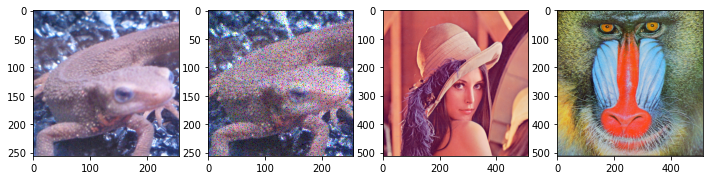

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256.png')
img_lena = io.imread('http://www.ess.ic.kanagawa-it.ac.jp/std_img/colorimage/lena_std.bmp')
img_noise = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_noise.png')
img_mandrill = io.imread('http://www.mis.med.akita-u.ac.jp/~kata/image/originalsource/mandrill.jpg')

plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(img_orig)
plt.subplot(1,4,2)
plt.imshow(img_noise)
plt.subplot(1,4,3)
plt.imshow(img_lena)
plt.subplot(1,4,4)
plt.imshow(img_mandrill)
plt.show()

In [40]:
# func_list

def rgb2gray(img):
    _img = img.copy().astype(np.float32)
    img_gray = 0.2126*_img[...,0] + 0.7153*_img[...,1] + 0.0722*_img[...,2]
    img_gray = np.clip(img_gray,0,255)
    return img_gray.astype(np.uint8)

def binary(img_gray,th):
    _img = img_gray.copy().astype(np.float32)
    img_binary = np.minimum(_img//th, 1)
    img_binary = np.clip(img_binary,0,255)
    return img_binary.astype(np.uint8)

def rgb2binary(img,th):
    _img = img.copy().astype(np.float32)
    img_gray = rgb2gray(_img)
    img_binary = binary(img_gray,th)
    return img_binary

def otsu_thresh(img):
    _img = img.copy().astype(np.float32)

    max_vari = -1
    max_th = -1

    for th in range(1,254):
        m0 = _img[_img <= th].mean()
        m1 = _img[_img >  th].mean()
        w0 = _img[_img <= th].size
        w1 = _img[_img > th].size
        vari = w0 * w1 / ((w0 + w1) ** 2) * ((m0 - m1) ** 2) 
        if vari > max_vari:
            max_vari = vari
            max_th = th

    return rgb2binary(_img, max_th), max_th

def rgb2hsv(img_rgb):
    #rgb -> hsv
    _img = img_rgb.copy().astype(np.float32)

    v_max = _img.max(axis=2)
    v_min = _img.min(axis=2)
    v_argmin = _img.argmin(axis=2)

    img_hsv = np.zeros_like(_img, dtype=np.float32)

    r, g, b = np.split(_img, 3, axis=2)
    r, g, b = r[..., 0], g[..., 0], b[..., 0]

    diff = np.maximum(v_max - v_min, 1e-10)

    #Hue
    ind = v_argmin == 2
    img_hsv[..., 0][ind] = 60 * (g - r)[ind] / diff[ind] + 60
    ind = v_argmin == 0
    img_hsv[..., 0][ind] = 60 * (b - g)[ind] / diff[ind] + 180
    ind = v_argmin == 1
    img_hsv[..., 0][ind] = 60 * (r - b)[ind] / diff[ind] + 300
    ind = v_max == v_min
    img_hsv[..., 0][ind] = 0
    # Saturation
    img_hsv[..., 1] = v_max - v_min
    # Value
    img_hsv[..., 2] = v_max

    return img_hsv

def hsv2rgb(img_hsv):
    #hsv -> rgb
    _img_hsv = img_hsv.copy().astype(np.float32)

    h, s, v = np.split(_img_hsv, 3, axis=2)
    h, s, v = h[..., 0], s[..., 0], v[..., 0]
    _h = h / 60
    x = s * (1 - np.abs(_h % 2 - 1))
    z = np.zeros_like(x)
    vals = np.array([[s, x, z], [x, s, z], [z, s, x], [z, x, s], [x, z, s], [s, z, x]])
    
    img_rgb = np.zeros_like(_img_hsv)
    
    for i in range(6):
        ind = _h.astype(int) == i
        for j in range(3):
            img_rgb[..., j][ind] = (v - s)[ind] + vals[i, j][ind]
            
    return np.clip(img_rgb, 0, 255).astype(np.uint8)


def color_subtraction(img,div):
    _img = img.copy().astype(np.float32)

    th = 256 // div
    return np.clip(_img // th * th + th // 2, 0 ,255).astype(np.uint8)

def ave_pooling(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    outer_h = h % ksize
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left

    _img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    for iy in range(0, new_h, ksize):
        for ix in range(0, new_w, ksize):
          for ic in range(c):
            out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].mean()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out, 0, 255).astype(np.uint8)

def max_pooling(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    outer_h = h % ksize
    pad_top = outer_h // 2
    pad_bottom = outer_h - pad_top
    outer_w = w % ksize
    pad_left = outer_w // 2
    pad_right = outer_w - pad_left

    _img = np.pad(_img, [(pad_top,pad_bottom),(pad_left,pad_right),(0,0)], 'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape) == 2 else out.shape[2]

    for iy in range(0, new_h, ksize):
        for ix in range(0, new_w, ksize):
          for ic in range(c):
            out[iy:iy+ksize, ix:ix+ksize, ic]=_img[iy:iy+ksize, ix:ix+ksize, ic].max()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out, 0, 255).astype(np.uint8)

def gaussian_filter(img, ksize, sigma):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    temp = np.zeros_like(_img)

    new_h, new_w = temp.shape[:2]
    c = 1 if len(temp.shape)==2 else temp.shape[2]

    k = np.zeros([ksize, ksize])
    for iy in range(ksize):
        for ix in range(ksize):
            k[ix, iy] = 1 / (2 * np.pi * (sigma**2)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

    k = k/k.sum()

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              temp[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = temp[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def median_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
                out[iy,ix,ic] = np.median(_img[iy:iy+ksize, ix:ix+ksize, ic])

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def smooth_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
                out[iy,ix,ic] = np.mean(_img[iy:iy+ksize, ix:ix+ksize, ic])

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def motion_filter(img, ksize):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    k[range(ksize), range(ksize)] = 1/ksize


    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

def maxmin_filter(img, ksize, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = _img[iy:iy+ksize, ix:ix+ksize, ic].max()-_img[iy:iy+ksize, ix:ix+ksize, ic].min()

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def diff_filter(img, mode="y", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)


    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    
    k = np.array([[0,0,0],[-1,1,0],[0,0,0]])
    if mode == 'y':
        k = np.array([[0,-1,0],[0,1,0],[0,0,0]])

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def prewitt_filter(img, ksize, mode="x", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    if mode == 'x':
        k[:, 0] = 1
        k[:, -1] = -1
    else:
        k[0] = 1
        k[-1] = -1
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def sobel_filter(img, ksize, mode="x", gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    if mode == 'x':
        k[:, 0] = 1
        k[ksize//2, 0] = 2
        k[:, -1] = -1
        k[ksize//2, -1] = -2
    else:
        k[0] = 1
        k[0, ksize//2] = 2
        k[-1] = -1
        k[-1, ksize//2] = -2
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def laplacian_filter(img, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def emboss_filter(img, gray_image=False):
    _img = img.copy().astype(np.float32)
    if not gray_image:
        _img = rgb2gray(img).copy().astype(np.float32)

    ksize = 3

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    if len(_img.shape) == 2:
        _img = np.expand_dims(_img, axis=-1)

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.array([[-2, -1, 0],[-1, 1, 1],[0, 1, 2]])
      
    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)[...,0]

def LoG_filter(img, k, sigma):
    _img = img.copy().astype(np.float32)

    h, w = _img.shape[:2]
    pad_top, pad_bottom = ksize, ksize
    pad_left, pad_right = ksize, ksize

    _img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
    out = np.zeros_like(_img)

    new_h, new_w = out.shape[:2]
    c = 1 if len(out.shape)==2 else out.shape[2]

    k = np.zeros([ksize, ksize])
    for iy in range(ksize):
        for ix in range(ksize):
            k[ix, iy] = ((ix - ksize//2)**2 + (iy - ksize//2)**2 - 2*(sigma**2)) / (2 * np.pi * (sigma**6)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

    k = k/k.sum()

    for iy in range(new_h - ksize):
        for ix in range(new_w - ksize):
            for ic in range(c):
              out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

    out = out[pad_top:pad_top+h, pad_left:pad_left+w]
    return np.clip(out,0,255).astype(np.uint8)

#11 平滑化フィルタ

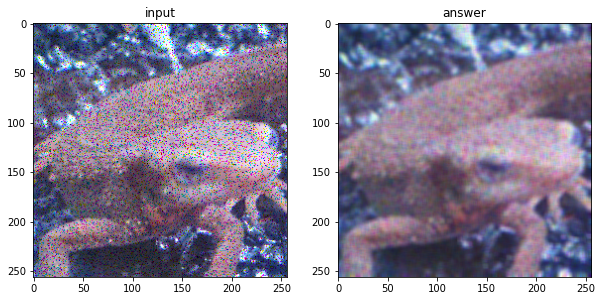

In [5]:
_img = img_noise.copy().astype(np.float32)
ksize = 5

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
            out[iy,ix,ic] = np.mean(_img[iy:iy+ksize, ix:ix+ksize, ic])

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_noise)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out)
plt.show()

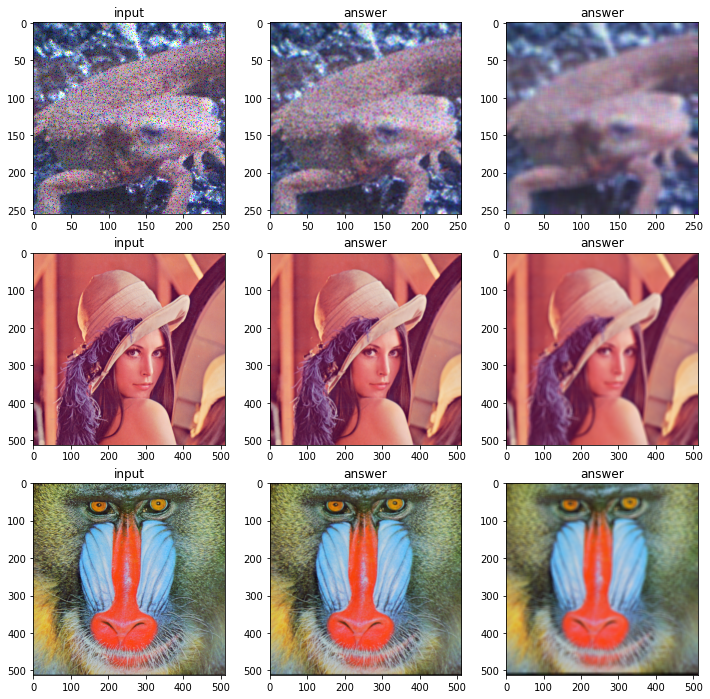

In [8]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.title('input')
plt.imshow(img_noise)

plt.subplot(3, 3, 2)
plt.title('answer')
img_med = smooth_filter(img_noise, 3)
plt.imshow(img_med)

plt.subplot(3, 3, 3)
plt.title('answer')
img_med = smooth_filter(img_noise, 9)
plt.imshow(img_med)

plt.subplot(3, 3, 4)
plt.title('input')
plt.imshow(img_lena)

plt.subplot(3, 3, 5)
plt.title('answer')
img_med = smooth_filter(img_lena, 3)
plt.imshow(img_med)

plt.subplot(3, 3, 6)
plt.title('answer')
img_med = smooth_filter(img_lena, 9)
plt.imshow(img_med)

plt.subplot(3, 3, 7)
plt.title('input')
plt.imshow(img_mandrill)

plt.subplot(3, 3, 8)
plt.title('answer')
img_med = smooth_filter(img_mandrill, 3)
plt.imshow(img_med)

plt.subplot(3, 3, 9)
plt.title('answer')
img_med = smooth_filter(img_mandrill, 9)
plt.imshow(img_med)

plt.show()

#12 モーションフィルタ

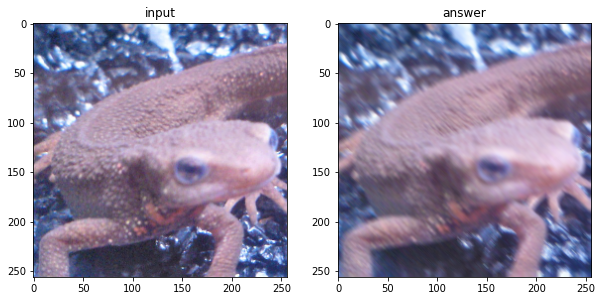

In [11]:
_img = img_orig.copy().astype(np.float32)
ksize = 5

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

k = np.zeros([ksize, ksize])
k[range(ksize), range(ksize)] = 1/ksize


for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out)
plt.show()

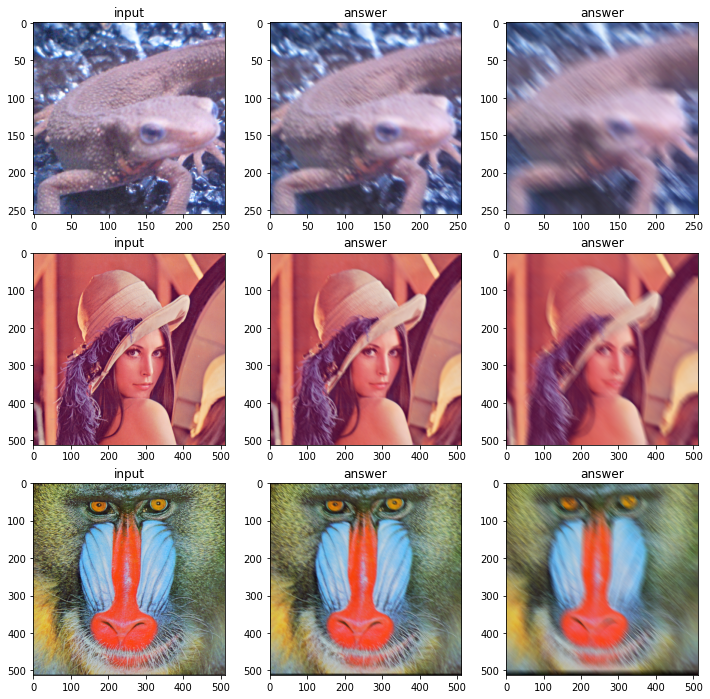

In [16]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.title('input')
plt.imshow(img_orig)

plt.subplot(3, 3, 2)
plt.title('answer')
img_med = motion_filter(img_orig, 5)
plt.imshow(img_med)

plt.subplot(3, 3, 3)
plt.title('answer')
img_med = motion_filter(img_orig, 15)
plt.imshow(img_med)

plt.subplot(3, 3, 4)
plt.title('input')
plt.imshow(img_lena)

plt.subplot(3, 3, 5)
plt.title('answer')
img_med = motion_filter(img_lena, 5)
plt.imshow(img_med)

plt.subplot(3, 3, 6)
plt.title('answer')
img_med = motion_filter(img_lena, 15)
plt.imshow(img_med)

plt.subplot(3, 3, 7)
plt.title('input')
plt.imshow(img_mandrill)

plt.subplot(3, 3, 8)
plt.title('answer')
img_med = motion_filter(img_mandrill, 5)
plt.imshow(img_med)

plt.subplot(3, 3, 9)
plt.title('answer')
img_med = motion_filter(img_mandrill, 15)
plt.imshow(img_med)

plt.show()

#13 Max-Minフィルタ

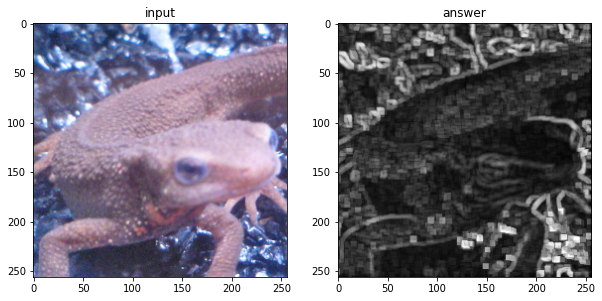

In [23]:
_img = rgb2gray(img_orig).copy().astype(np.float32)
ksize = 5

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

if len(_img.shape) == 2:
    _img = np.expand_dims(_img, axis=-1)

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = _img[iy:iy+ksize, ix:ix+ksize, ic].max()-_img[iy:iy+ksize, ix:ix+ksize, ic].min()

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out[...,0], cmap='gray')
plt.show()

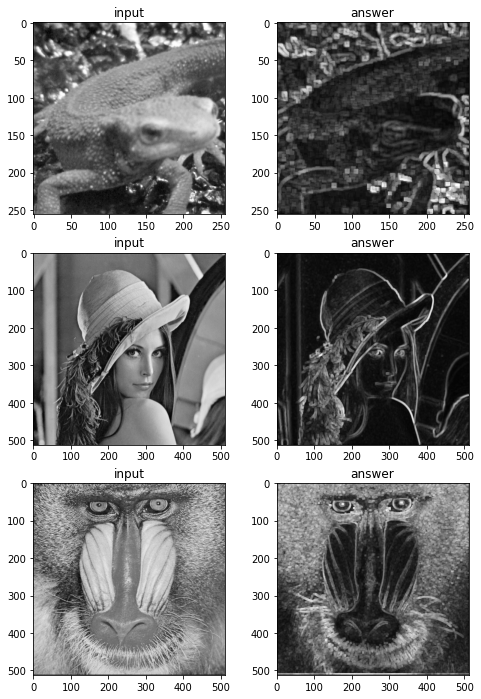

In [33]:
plt.figure(figsize=(8, 12))
plt.subplot(3, 2, 1)
plt.title('input')
plt.imshow(rgb2gray(img_orig), cmap='gray')

plt.subplot(3, 2, 2)
plt.title('answer')
img_med = maxmin_filter(img_orig, 5)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 2, 3)
plt.title('input')
plt.imshow(rgb2gray(img_lena), cmap='gray')

plt.subplot(3, 2, 4)
plt.title('answer')
img_med = maxmin_filter(rgb2gray(img_lena), 5, gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 2, 5)
plt.title('input')
plt.imshow(rgb2gray(img_mandrill), cmap='gray')

plt.subplot(3, 2, 6)
plt.title('answer')
img_med = maxmin_filter(img_mandrill, 5)
plt.imshow(img_med, cmap='gray')

plt.show()

#14 微分フィルタ

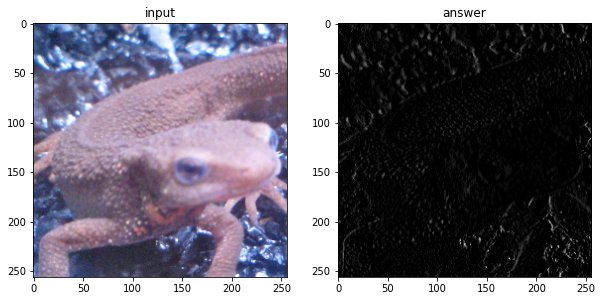

In [31]:
_img = rgb2gray(img_orig).copy().astype(np.float32)
ksize = 3

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

if len(_img.shape) == 2:
    _img = np.expand_dims(_img, axis=-1)

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

k = np.array([[0,0,0],[-1,1,0],[0,0,0]])

for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out[...,0], cmap='gray')
plt.show()

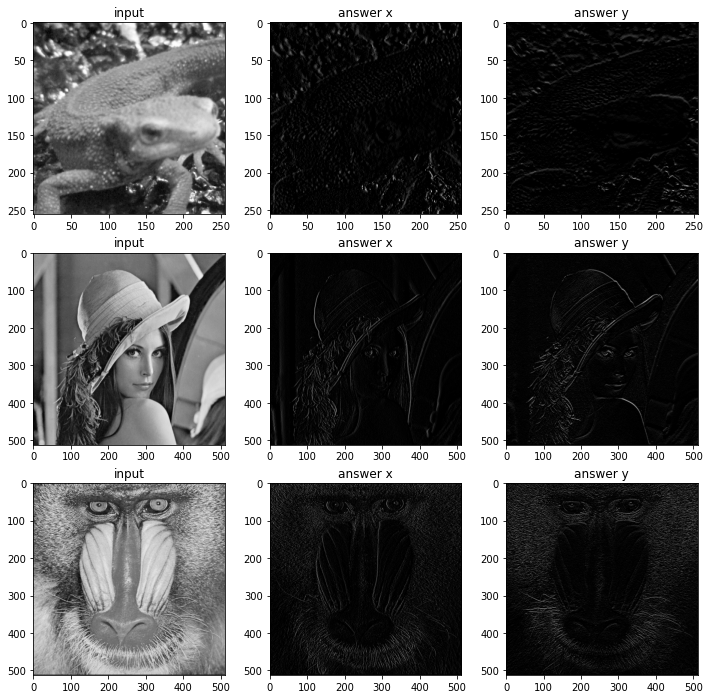

In [45]:
img_orig_gray = rgb2gray(img_orig)
img_lena_gray = rgb2gray(img_lena)
img_mandrill_gray = rgb2gray(img_mandrill)

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.title('input')
plt.imshow(img_orig_gray, cmap='gray')

plt.subplot(3, 3, 2)
plt.title('answer x')
img_med = diff_filter(img_orig, mode='x')
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 3)
plt.title('answer y')
img_med = diff_filter(img_orig_gray, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 4)
plt.title('input')
plt.imshow(img_lena_gray, cmap='gray')

plt.subplot(3, 3, 5)
plt.title('answer x')
img_med = diff_filter(img_lena_gray, mode='x', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 6)
plt.title('answer y')
img_med = diff_filter(img_lena_gray, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 7)
plt.title('input')
plt.imshow(img_mandrill_gray, cmap='gray')

plt.subplot(3, 3, 8)
plt.title('answer x')
img_med = diff_filter(img_mandrill_gray, mode='x', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 9)
plt.title('answer y')
img_med = diff_filter(img_mandrill_gray, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.show()

#15 プリューウィットフィルタ

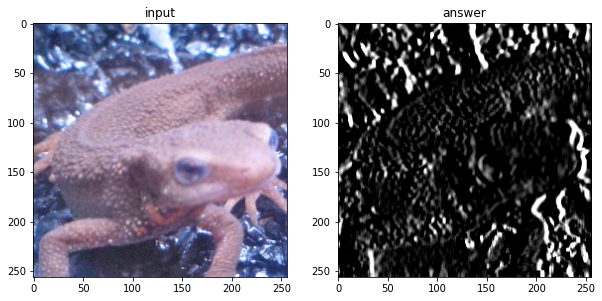

In [5]:
_img = rgb2gray(img_orig).copy().astype(np.float32)
ksize = 5

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

if len(_img.shape) == 2:
    _img = np.expand_dims(_img, axis=-1)

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

k = np.zeros([ksize, ksize])
k[:, 0] = 1
k[:, -1] = -1
  
for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out[...,0], cmap='gray')
plt.show()

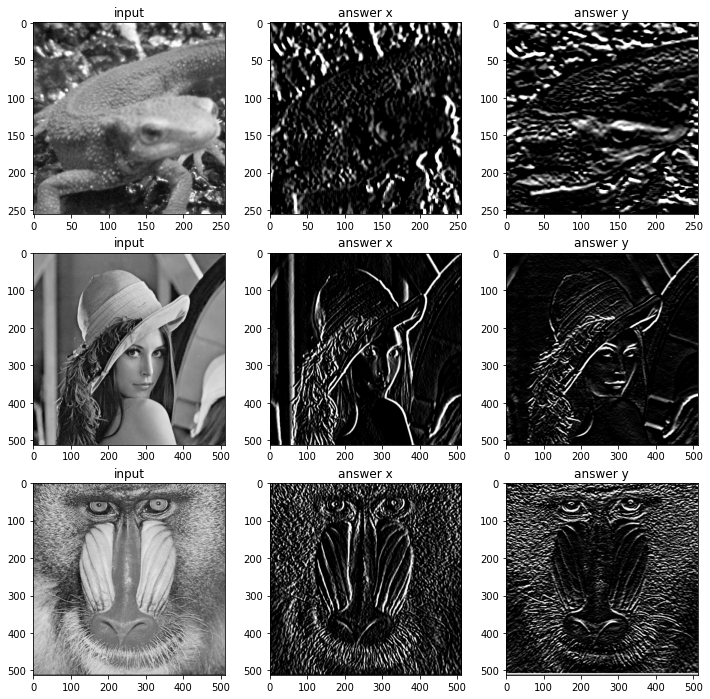

In [10]:
img_orig_gray = rgb2gray(img_orig)
img_lena_gray = rgb2gray(img_lena)
img_mandrill_gray = rgb2gray(img_mandrill)

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.title('input')
plt.imshow(img_orig_gray, cmap='gray')

plt.subplot(3, 3, 2)
plt.title('answer x')
img_med = prewitt_filter(img_orig, 5, mode='x')
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 3)
plt.title('answer y')
img_med = prewitt_filter(img_orig_gray, 5, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 4)
plt.title('input')
plt.imshow(img_lena_gray, cmap='gray')

plt.subplot(3, 3, 5)
plt.title('answer x')
img_med = prewitt_filter(img_lena_gray, 5, mode='x', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 6)
plt.title('answer y')
img_med = prewitt_filter(img_lena_gray, 5, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 7)
plt.title('input')
plt.imshow(img_mandrill_gray, cmap='gray')

plt.subplot(3, 3, 8)
plt.title('answer x')
img_med = prewitt_filter(img_mandrill_gray, 5, mode='x', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 9)
plt.title('answer y')
img_med = prewitt_filter(img_mandrill_gray, 5, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.show()

#16 ソーベルフィルタ

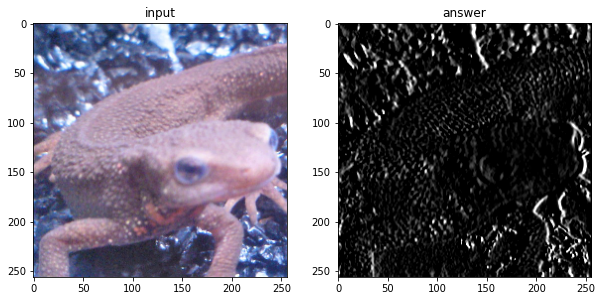

In [15]:
_img = rgb2gray(img_orig).copy().astype(np.float32)
ksize = 3

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

if len(_img.shape) == 2:
    _img = np.expand_dims(_img, axis=-1)

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

k = np.zeros([ksize, ksize])
k[:, 0] = 1
k[ksize//2, 0] = 2
k[:, -1] = -1
k[ksize//2, -1] = -2
  
for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out[...,0], cmap='gray')
plt.show()

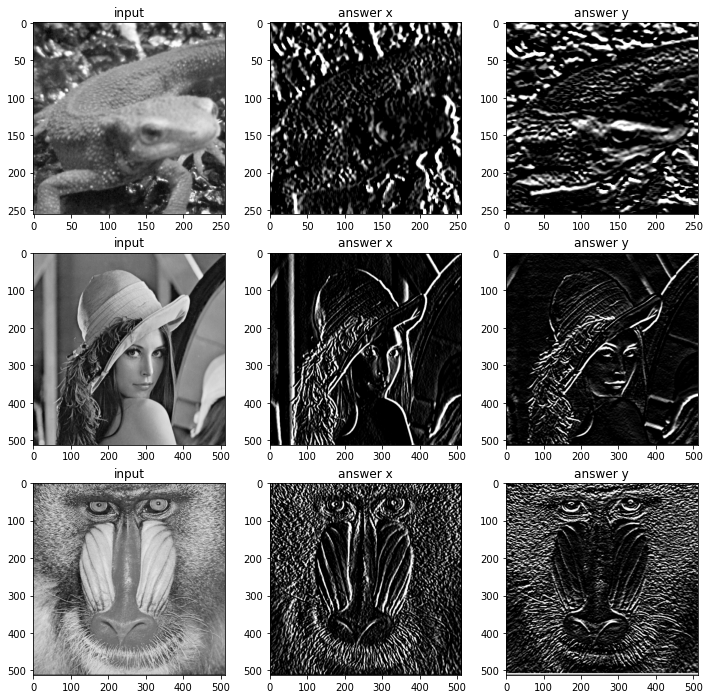

In [17]:
img_orig_gray = rgb2gray(img_orig)
img_lena_gray = rgb2gray(img_lena)
img_mandrill_gray = rgb2gray(img_mandrill)

plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.title('input')
plt.imshow(img_orig_gray, cmap='gray')

plt.subplot(3, 3, 2)
plt.title('answer x')
img_med = sobel_filter(img_orig, 5, mode='x')
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 3)
plt.title('answer y')
img_med = sobel_filter(img_orig_gray, 5, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 4)
plt.title('input')
plt.imshow(img_lena_gray, cmap='gray')

plt.subplot(3, 3, 5)
plt.title('answer x')
img_med = sobel_filter(img_lena_gray, 5, mode='x', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 6)
plt.title('answer y')
img_med = sobel_filter(img_lena_gray, 5, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 7)
plt.title('input')
plt.imshow(img_mandrill_gray, cmap='gray')

plt.subplot(3, 3, 8)
plt.title('answer x')
img_med = sobel_filter(img_mandrill_gray, 5, mode='x', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 3, 9)
plt.title('answer y')
img_med = sobel_filter(img_mandrill_gray, 5, mode='y', gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.show()

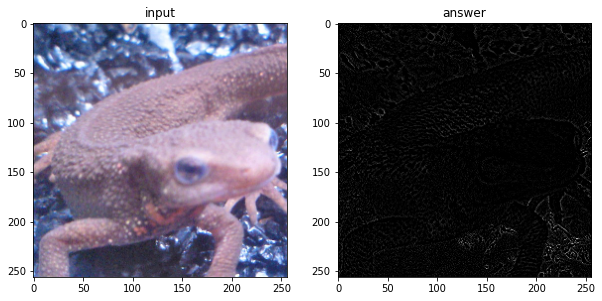

In [20]:
_img = rgb2gray(img_orig).copy().astype(np.float32)
ksize = 3

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

if len(_img.shape) == 2:
    _img = np.expand_dims(_img, axis=-1)

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

k = np.array([[0,1,0],[1,-4,1],[0,1,0]])

  
for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out[...,0], cmap='gray')
plt.show()

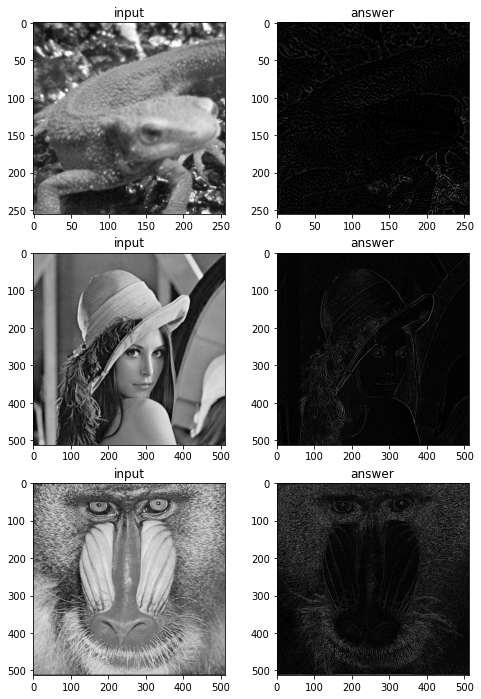

In [31]:
img_orig_gray = rgb2gray(img_orig)
img_lena_gray = rgb2gray(img_lena)
img_mandrill_gray = rgb2gray(img_mandrill)

plt.figure(figsize=(8, 12))
plt.subplot(3, 2, 1)
plt.title('input')
plt.imshow(img_orig_gray, cmap='gray')

plt.subplot(3, 2, 2)
plt.title('answer')
img_med = laplacian_filter(img_orig_gray, gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 2, 3)
plt.title('input')
plt.imshow(img_lena_gray, cmap='gray')

plt.subplot(3, 2, 4)
plt.title('answer')
img_med = laplacian_filter(img_lena)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 2, 5)
plt.title('input')
plt.imshow(img_mandrill_gray, cmap='gray')

plt.subplot(3, 2, 6)
plt.title('answer')
img_med = laplacian_filter(img_mandrill)
plt.imshow(img_med, cmap='gray')

plt.show()

#18 エンボスフィルタ

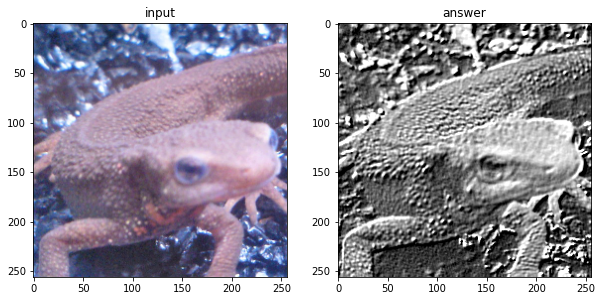

In [32]:
_img = rgb2gray(img_orig).copy().astype(np.float32)
ksize = 3

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

if len(_img.shape) == 2:
    _img = np.expand_dims(_img, axis=-1)

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

k = np.array([[-2,-1,0],[-1,1,1],[0,1,2]])

  
for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out[...,0], cmap='gray')
plt.show()

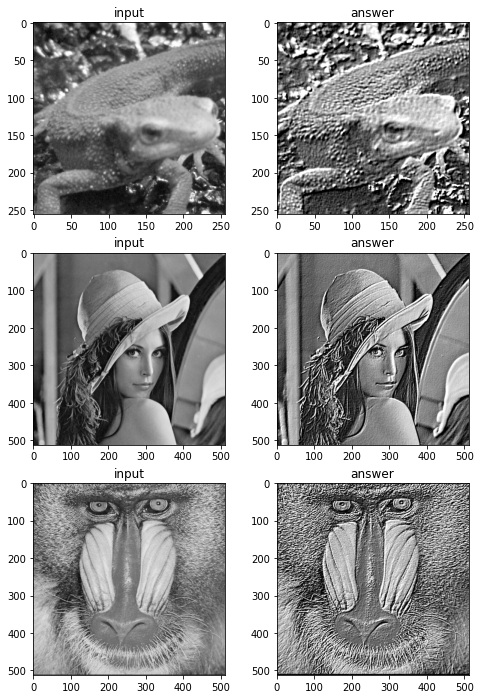

In [34]:
img_orig_gray = rgb2gray(img_orig)
img_lena_gray = rgb2gray(img_lena)
img_mandrill_gray = rgb2gray(img_mandrill)

plt.figure(figsize=(8, 12))
plt.subplot(3, 2, 1)
plt.title('input')
plt.imshow(img_orig_gray, cmap='gray')

plt.subplot(3, 2, 2)
plt.title('answer')
img_med = emboss_filter(img_orig_gray, gray_image=True)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 2, 3)
plt.title('input')
plt.imshow(img_lena_gray, cmap='gray')

plt.subplot(3, 2, 4)
plt.title('answer')
img_med = emboss_filter(img_lena)
plt.imshow(img_med, cmap='gray')

plt.subplot(3, 2, 5)
plt.title('input')
plt.imshow(img_mandrill_gray, cmap='gray')

plt.subplot(3, 2, 6)
plt.title('answer')
img_med = emboss_filter(img_mandrill)
plt.imshow(img_med, cmap='gray')

plt.show()

#19 LoGフィルタ

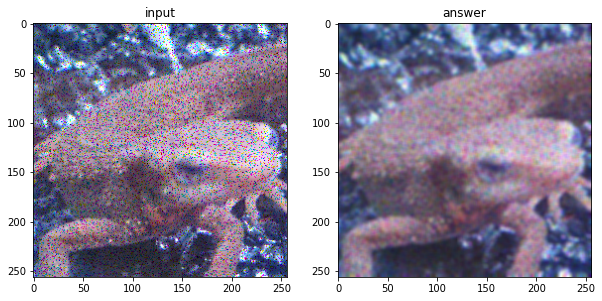

In [39]:
img_noise_orig = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_noise.png')

_img = img_noise_orig.copy().astype(np.float32)
ksize = 5
sigma = 3

h, w = _img.shape[:2]
pad_top, pad_bottom = ksize, ksize
pad_left, pad_right = ksize, ksize

_img = np.pad(_img, [(pad_top, pad_bottom),(pad_left, pad_right),(0,0)],'edge')
out = np.zeros_like(_img)

new_h, new_w = out.shape[:2]
c = 1 if len(out.shape)==2 else out.shape[2]

k = np.zeros([ksize, ksize])
for iy in range(ksize):
    for ix in range(ksize):
        k[ix, iy] = ((ix - ksize//2)**2 + (iy - ksize//2)**2 - 2*(sigma**2)) / (2 * np.pi * (sigma**6)) * np.exp(-((ix - ksize//2)**2 + (iy - ksize//2)**2)/(2*sigma**2))

k = k/k.sum()

for iy in range(new_h - ksize):
    for ix in range(new_w - ksize):
        for ic in range(c):
          out[iy,ix,ic] = np.sum(_img[iy:iy+ksize, ix:ix+ksize, ic]*k)

out = out[pad_top:pad_top+h, pad_left:pad_left+w]
out = np.clip(out,0,255).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)
plt.subplot(1, 2, 2)
plt.title('answer')
plt.imshow(out)
plt.show()

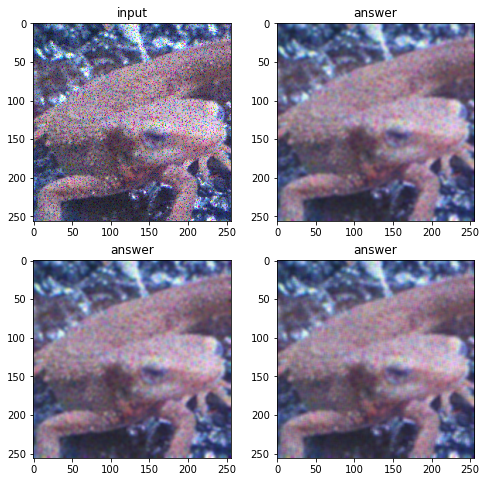

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)

img_log = LoG_filter(img_noise_orig, 5, sigma=3)
plt.subplot(2, 2, 2)
plt.title('answer')
plt.imshow(img_log)

img_log = LoG_filter(img_noise_orig, 12, sigma=3)
plt.subplot(2, 2, 3)
plt.title('answer')
plt.imshow(img_log)

img_log = LoG_filter(img_noise_orig, 9, sigma=9)
plt.subplot(2, 2, 4)
plt.title('answer')
plt.imshow(img_log)

plt.show()

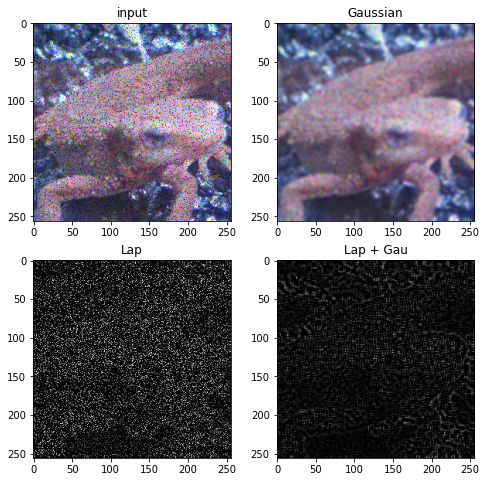

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.title('input')
plt.imshow(img_noise_orig)

img_gau = gaussian_filter(img_noise_orig, 5, sigma=3)
plt.subplot(2, 2, 2)
plt.title('Gaussian')
plt.imshow(img_gau)

img_lapl = laplacian_filter(img_noise_orig)
plt.subplot(2, 2, 3)
plt.title('Lap')
plt.imshow(img_lapl, cmap='gray')

img_lapl = laplacian_filter(img_gau)
plt.subplot(2, 2, 4)
plt.title('Lap + Gau')
plt.imshow(img_lapl, cmap='gray')

plt.show()

#20 ヒストグラム

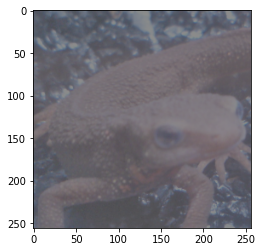

In [52]:
img_dark = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/assets/imori_256x256_dark.png')
plt.imshow(img_dark)
plt.show()

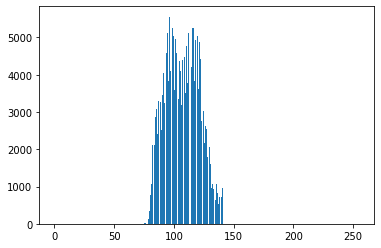

In [56]:
plt.hist(img_dark.ravel(), bins=255, rwidth=0.8, range=(0, 255))
plt.show()